In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")
clip = 10.

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="self_trigger_output")(x)
    actor = Model(inputs=action_input, outputs=x)
    # actor.summary()
    # actor.set_weights(_actor_initial_weight(actor))
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        original_noise = False,
        clip_com = 0.01
    )
    return agent

In [13]:
#safe learning
l = 5. # cost dependency for tau
step = 200000  # num of interval
episode_step = step
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor.load_weights('./saved_agent/self_trigger.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=0, step_log=True, nb_max_episode_steps=episode_step)

76118: tau = 0.10000000149011612, state = [-0.54892105  1.82844913]625e+00]]

In [14]:
states = []
taus = []
high = np.array([np.pi, 8])
for _ in range(500):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = a.forward(x)
    taus.append(action[1])
states = np.array(states)

<IPython.core.display.Javascript object>


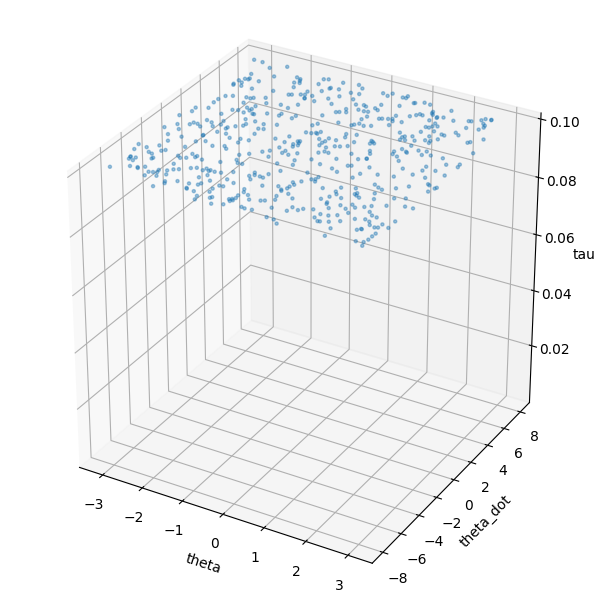

In [16]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)

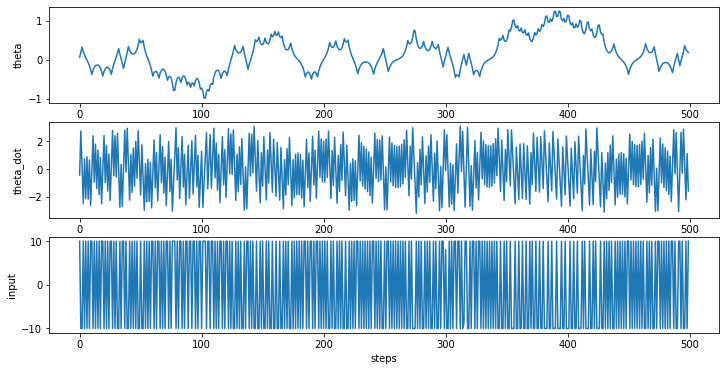

In [29]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
inputs = []
reward = 0
for i in range(500):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    inputs.append(a_agent)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,r,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
    reward += - 0.01 * a_agent**2 + l * tau
states, inputs = np.array(states), np.array(inputs)

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(3,1,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.subplot(3,1,3)
plt.xlabel('steps')
plt.ylabel('input')
plt.plot(range(inputs.shape[0]), inputs)
plt.show()

In [18]:
n_states = 500
n_agents = 10
states = []
high = np.array([np.pi, 8])
for _ in range(n_states):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
states = np.array(states)

In [19]:
all_agents_taus = np.zeros((n_agents, n_states))
ag = agent((2,),(2,))
moth = int(len(a.agents_log)/10)
for i, age in enumerate(a.agents_log):
    if i % moth != 0:
        continue
    ag.agent_copy_from_layers(age)
    taus = []
    for x in states:
        action = ag.forward(x)
        taus.append(action[1])
    all_agents_taus[int(i/moth)] = taus

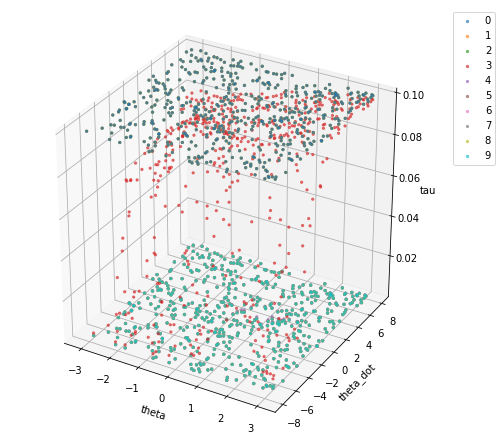

In [20]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

for i, tauss in enumerate(all_agents_taus):
    ax.scatter3D(states[:,0], states[:,1], tauss, marker='.', alpha=0.6, label=f'{i}')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [17]:
watched_states = np.copy(a.watched_states)

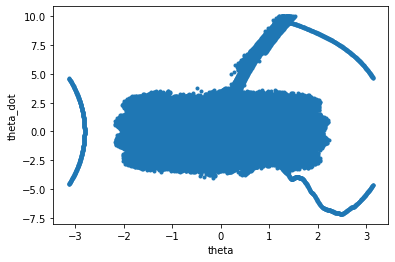

In [18]:
%matplotlib inline
def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2 * np.pi
    th = np.sign(th) * r
    return th

thetas, theta_dots = [], []
for theta, theta_dot in watched_states:
    if abs(theta_dot) > 10:
        continue
    thetas.append(rad_clip(theta))
    theta_dots.append(theta_dot)
plt.xlabel('theta')
plt.ylabel('theta_dot')
plt.scatter(thetas, theta_dots, marker='.')
plt.show()

In [28]:
states = []
taus = []
high = np.array([np.pi, 10])
ag.agent_copy_from_layers(a.agents_log[150])
for _ in range(5000):
    x = np.random.uniform(low=-high, high=high)
    states.append(x)
    action = ag.forward(x)
    taus.append(action[1])
states = np.array(states)

<IPython.core.display.Javascript object>


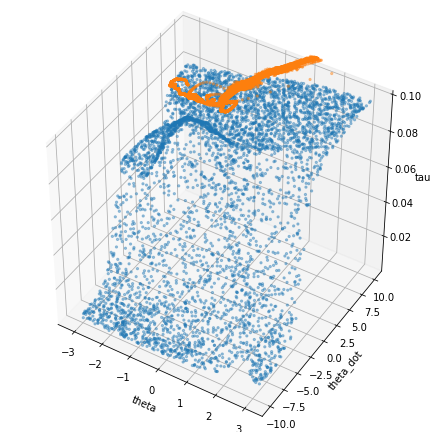

In [30]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.001,0.1)

ax.scatter3D(states[:,0], states[:,1], taus, marker='.', alpha=0.4)
ax.scatter3D(thetas, theta_dots, 0.11 * np.ones((len(thetas),)), marker='.', alpha=0.4)

In [26]:
his = out.history

In [27]:
print(his)

{'episode_average_tau': [0.004716554195125108, 0.045096521811173844, 0.0998639709288531, 0.0999336289887381, 0.09995477661342904, 0.09995703627862552, 0.0999648101849131, 0.09995876754274463, 0.0999324100442452, 0.09991198527340842], 'episode_reward': [-0.39204653540250667, -7746.16762640265, -31563.6765610853, -31672.928961211175, -31569.72084280192, -31689.130051017302, -31387.831890423473, -31381.139840966975, -31775.573461578235, -31579.992741631035], 'nb_episode_steps': [2126, 222, 101, 101, 101, 101, 101, 101, 101, 101], 'nb_steps': [2126, 2348, 2449, 2550, 2651, 2752, 2853, 2954, 3055, 3156]}


In [36]:
print(a.actor.layers[4].get_weights())

[array([[-0.5880315 , -2.5594857 ],
       [ 0.64050776, -2.2610283 ],
       [-0.26306418, -2.6938398 ],
       [-0.5519071 , -1.4007633 ],
       [ 0.7026147 , -2.676629  ],
       [ 0.84687173, -0.14816345],
       [ 0.77983916,  0.16050911],
       [ 0.49343598, -2.3759453 ],
       [ 0.75950205, -2.2260284 ],
       [-0.6051158 , -2.6793804 ],
       [-0.53853226, -1.8909254 ],
       [-0.44172445, -2.9352703 ],
       [-0.38111737, -2.4922163 ],
       [ 0.44768667,  0.1419263 ],
       [-0.14825328,  0.17478968],
       [ 0.69327945, -2.7839382 ]], dtype=float32), array([ 0.14224249, -2.1089306 ], dtype=float32)]


In [54]:
states = []
inputs = []
high = np.array([np.pi, 8])
ag = agent((2,),(2,))
ag.actor.load_weights('./saved_agent/self_trigger.h5')
for _ in range(1000):
    x = np.random.uniform(low=-high, high=high)
    inputs.append(a.forward(x)[0])
    states.append(x)
states, inputs = np.array(states), np.array(inputs)

<IPython.core.display.Javascript object>


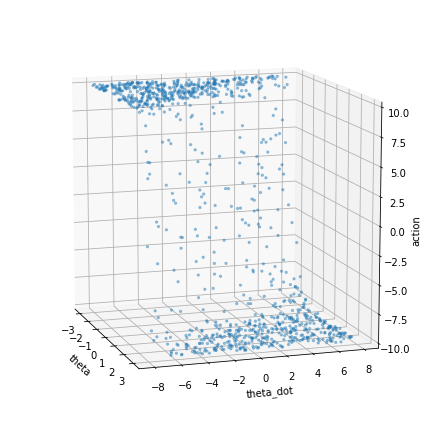

In [55]:
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('action')
ax.set_zlim3d(-10.,10.)

ax.scatter3D(states[:,0], states[:,1], inputs, marker='.', alpha=0.4)